In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing

# Data Analysis Project — Telco Churn

### by Brian Clements 29 November 2021

## GOALS

### The goal of this project is to explore factors related to customer churn at Telco, and to develop a machine learning model in an attempt to predict future churn. 

## DESCRIPTION

### Gaining new customers is an expensive proposition for a telecom company--much more economical is their retention.  This project is an exploration of our customers' churn through a database of information related to their accounts. Certain demographic information will be looked at, as well as what types of services and contracts they have, charges, and use behavior (e.g. tenure and churn).  From this analysis, we will move develop a model to predict future customer churn (delivered in a csv file) and recommendations to reduce their attrition.

## Initial questions
1. Are those with dependents paying less?
2. Are people with paperless billing being charged differently? More or less?
3. Are people with longer tenure being charged more? Less? Different services?
4. Is there a reason for the churn amongst those who pay with electronic check?

## Executive Summary:

- A lot of insight was gained into our customers and there attrition, including useful points that will help guide the company take actions to reduce it.

- The modelling that has been done in this report is, unfortunately, somewhat limited in that it has so far been mostly unable to beat our baseline churn prediction by very much.

- GROUP PLANS and AUTOMATIC PAYMENT methods are the biggest general recommendation. We recommend targeting this segment for loyalty.

- We found that churn goes down as total charges go up--up to a point.  We recommend offering discounts or other incentives to prevent the "churn bump" that occurs at about $2500 of total charges.

## DATA DICTIONARY: 

| Variable    | Meaning     |
| ----------- | ----------- |
|
| customer_id     | Unique identifier for each customer |
| gender | Sex of the customer | 
| senior_citizen     | Is the customer a senior citizen? |
| partner       | Does the cust. have a partner? |
| dependents   | Does the cust. have dependents?|
| tenure  | How long has the cust. been with us? |
| phone_service     | Does the cust. have phone svc.?|
| multiple_lines    | Does the cust. have multiple lines? |
| online_security  | Does the cust. have online security |
| online_backup    | Does the cust. have online backup |
| device_protection    | Does the cust. have device protection? |
| tech_support     | Does the cust. have tech support? |
| streaming_tv    | Does the cust. have streaming tv? |
| streaming_movies    | Does the cust. have streaming movies? |
| paperless_billing   |Does the cust. have paperless billing? |
| monthly_charges  | Customer monthly charges |
| total_charges     | Customer total charges |
| churn             | Has the customer churned? |
| contract_type     | Contract type |
| internet_service_type  | Internet type |
| payment_type          | Payment type |
| gender_Male         |Encoded feature: Customer sex |
| partner_Yes        | Encoded feature: does the cust. have a partner? | 
| dependents_Yes   | Encoded feature: does the cust. have dependents? |
| phone_service_Yes   | Encoded feature: does the cust. have phone service?|
| multiple_lines_No phone service   |   Encoded feature: multiple lines? (no service option) |
| multiple_lines_Yes | Encoded feature: multiple lines?  ("yes" option; the final option would be "no")
| online_security_No internet service  |  Encoded feature: online security?  (no service option)
| online_security_Yes | Encoded feature: online security?  ("yes" option; the final option would be "no")
| online_backup_No internet service  |  Encoded feature: online backup?  (no service option)
| online_backup_Yes | Encoded feature: online backup?  ("yes" option; the final option would be "no")
| device_protection_No internet service |  Encoded feature: device prot.?  (no service option)
| device_protection_Yes | Encoded feature: device prot.?  ("yes" option; the final option would be "no")
| tech_support_No internet service |  Encoded feature: tech support?  (no service option)
| tech_support_Yes | Encoded feature: tech support?  ("yes" option; the final option would be "no")  
| streaming_tv_No internet service  |  Encoded feature: streaming tv?  (no service option)
| streaming_tv_Yes | Encoded feature: streaming tv?  ("yes" option; the final option would be "no")
| streaming_movies_No internet service|  Encoded feature: streaming movies?  (no service option)
| streaming_movies_Yes | Encoded feature: streaming movies?  ("yes" option; the final option would be "no")
| paperless_billing_Yes |  Encoded feature: paperless billing?  
| churn_Yes |  Encoded feature: is there churn on the account?
| contract_type_One year | Encoded feature: contract type  ("one year" option)
| contract_type_Two year | Encoded feature: contract type  ("two year" option; the final option would be "month-to-month")
| internet_service_type_Fiber optic | Encoded feature: internet type  ("fiber optic" option)
| internet_service_type_None| Encoded feature: contract type  ("no svc." option; the final option would be "DSL")  
| payment_type_Credit card (automatic)  | Encoded feature: payment type  ("credit card")
| payment_type_Electronic check | Encoded feature: payment type  ("electronic check" option)
| payment_type_Mailed check | Encoded feature: payment type  ("mailed check" option; the final option would be "bank transfer")

## Wrangle the data

To acquire the telco data, I relied on a function that I built and stored in my acquire.py file.  This function pulls the telco dataset (and in its absence, queries the Codeup database using SQL to build it from scratch)

In [2]:
# Create and check the telco dataframe
raw_telco_df = acquire.get_telco_data()
raw_telco_df.sample(1)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2092,3,1,1,7319-VENRZ,Male,0,No,No,7,Yes,...,Yes,Yes,No,No,64.3,445.95,No,Month-to-month,DSL,Bank transfer (automatic)


## Clean and split the data

I utilized my prep_telco and split_telco_data functions from prepare.py to get the data ready

There were no issues with "tidiness," but there were a few items that needed to be cleaned, not least of all the data type for 'total_charges' and several NaN values in that feature

### Missing values: in the total_charges feature, I replaced the missing values with zeroes; these cells seemed to represent new customers who had yet to accumulate charges.

### Additionally, the total_charges column has a few values that do not equal their 'tenure' multiplied by 'monthly_charges;' I chose not to make any changes, in case these values possibly represented customers whose monthly charges have changed over time.


In [3]:
# Create a dataframe for the prepared telco data from my prepare.py file.
telco_prepped = prepare.prep_telco(raw_telco_df)

In [4]:
#Here, we reassign the three values returned from the split_data function to new variables
telco_train, telco_validate, telco_test = prepare.split_telco_data(telco_prepped)
print(f'telco_train: {telco_train.shape}')
print(f'telco_validate: {telco_validate.shape}')
print(f'telco_test: {telco_test.shape}')

telco_train: (3943, 61)
telco_validate: (1691, 61)
telco_test: (1409, 61)


In [5]:
# Create X & y version of train, where y is a series with just the target variable and X are all the features. 

telco_X_train = telco_train.drop(columns=['churn_Yes'])
telco_y_train = telco_train.churn_Yes

telco_X_validate = telco_validate.drop(columns=['churn_Yes'])
telco_y_validate = telco_validate.churn_Yes

telco_X_test = telco_test.drop(columns=['churn_Yes'])
telco_y_test = telco_test.churn_Yes

# At this point, we now have our train, validate, test data sets

- We will set alpha to 0.05 for all subsequent stats tests

In [6]:
alpha = 0.05

## Research Question 1
Are those with dependents paying less? What about their churn? We can see in the next cell that they churn less.

No handles with labels found to put in legend.


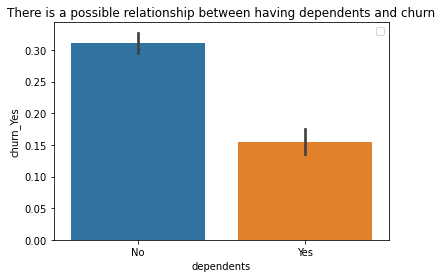

In [7]:
# Here, we graphically represent the relationship between having dependents and churn using a barplot.

plt.title("There is a possible relationship between having dependents and churn")
sns.barplot(y=telco_y_train, x="dependents", data=telco_X_train)
plt.legend()
plt.show()

# The next step will be a stat test: chi^2

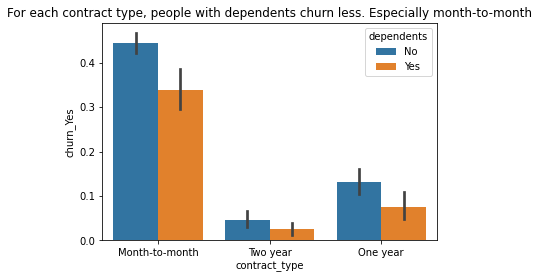

In [8]:
# The code in this cell creates a seaborns barplot using hue to distignuish between having dependents and not.

plt.title("For each contract type, people with dependents churn less. Especially month-to-month")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="dependents")
plt.show()

In [9]:
# This code creates a crosstab for depedents and churn, to be used in a stats test in the next cell

observed_dependents = pd.crosstab(telco_X_train.dependents, telco_y_train)
observed_dependents

churn_Yes,0,1
dependents,,
No,1917,866
Yes,980,180


### Hypothesis to test in a stats test regarding dependents:   
    - 𝐻𝑜 : having dependents is unrelated to churn
    - 𝐻𝑎 : having dependents is related to churn
    
    - We reject the null hypothesis

In [10]:
# This cell performs a chi^2 test on the observed_dependents crosstab above.
chi2, p, degf, expected = stats.chi2_contingency(observed_dependents)
print('Observed\n')
print(observed_dependents.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1917  866]
 [ 980  180]]
---
Expected

[[2044  738]
 [ 852  307]]
---

chi^2 = 101.4319
p     = 0.0000
We reject the null hypothesis


No handles with labels found to put in legend.


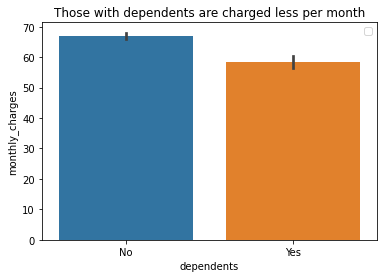

In [11]:
plt.title("Those with dependents are charged less per month")
sns.barplot(y="monthly_charges", x="dependents", data=telco_X_train)
plt.legend()
plt.show()

No handles with labels found to put in legend.


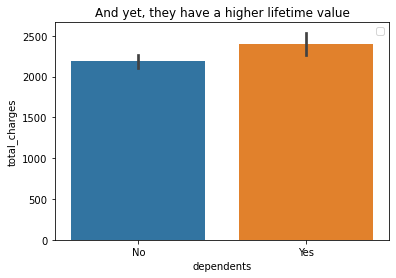

In [12]:
plt.title("And yet, they have a higher lifetime value")
sns.barplot(y="total_charges", x="dependents", data=telco_X_train)
plt.legend()
plt.show()

In [110]:
# Commented out for time purposes

# # Seaborns barplot comparing contract type/dependents to monthly charges.  
# plt.title("For each contract type, people with dependents pay less")
# sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="dependents")
# plt.show()

### Answer to Research Question 1:

Our chi^2 test shows that we can proceed with the understanding that customers with dependents churn less; additionally, it is clear from the charts that they are charged less but still provide a higher lifetime value.

## Research Question 2
We know that people with paperless billing churn at a higher rate; could this be related to their contract type, or perhaps higher monthly charges?

No handles with labels found to put in legend.


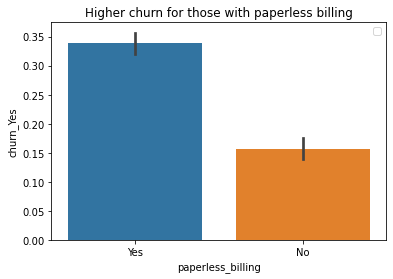

In [14]:
# Here, we see the relationship between paperless billing and churn.
plt.title("Higher churn for those with paperless billing")
sns.barplot(y=telco_y_train, x="paperless_billing", data=telco_X_train)
plt.legend()
plt.show()

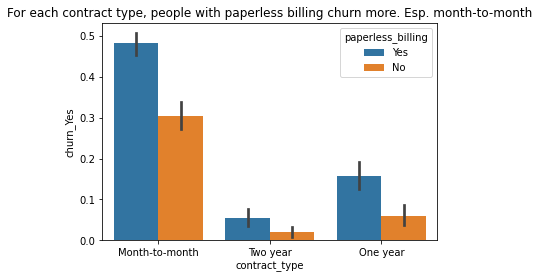

In [15]:
#monthly charges, paperless billing, churn, contract type

# For each contract type, people with dependents churn less
plt.title("For each contract type, people with paperless billing churn more. Esp. month-to-month")
sns.barplot(x="contract_type", y=telco_y_train, data=telco_X_train, hue="paperless_billing")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

In [16]:
# This cell creates a crosstab for use in a stats test below.

observed_billing = pd.crosstab(telco_X_train.paperless_billing, telco_y_train)

### My hypotheses regarding paperless billing and churn
    
    - 𝐻𝑜 : having paperless billing is unrelated to churn
    - 𝐻𝑎 : having paperless billing is related to churn
    
    - We rejected the null hypothesis

In [17]:
# The following code runs a 
chi2, p, degf, expected = stats.chi2_contingency(observed_billing)
print('Observed\n')
print(observed_billing.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[1341  250]
 [1556  796]]
---
Expected

[[1168  422]
 [1728  623]]
---

chi^2 = 159.1216
p     = 0.0000
We reject the null hypothesis


No handles with labels found to put in legend.


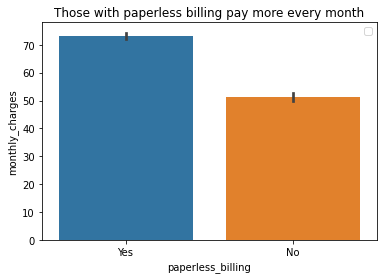

In [18]:
plt.title("Those with paperless billing pay more every month")
sns.barplot(y="monthly_charges", x="paperless_billing", data=telco_X_train)
plt.legend()
plt.show()

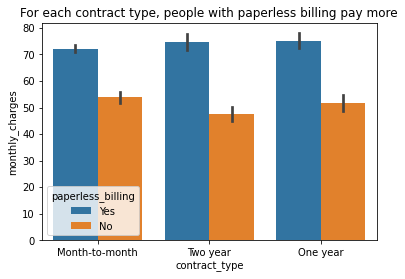

In [19]:
# For each contract type, people with dependents churn less
plt.title("For each contract type, people with paperless billing pay more")
sns.barplot(x="contract_type", y='monthly_charges', data=telco_X_train, hue="paperless_billing")
#population_survival_rate = train.survived.mean()
#plt.axhline(population_survival_rate)
plt.show()

### Answer to Research Question 2:

Our chi^2 test shows that we can proceed with the understanding that paperless billing is related to churn; these customers also pay more every month.

## Research Question 3
Are people with longer tenure creating more long-term value? 

In [111]:
# Commented out for time's sake.  The next visual is more helpful.

# # This cell creates a chart showing customer tenure and monthly charges, differentiated by churn ("1" = Churn, "0" = No Churn)
# plt.figure(figsize=(15,6))
# plt.title("There is an apparent relationship between tenure and monthly charges")
# sns.scatterplot(y='monthly_charges', x="tenure", data=telco_X_train, hue=telco_y_train)
# plt.legend()
# plt.show()
# plt.tight_layout

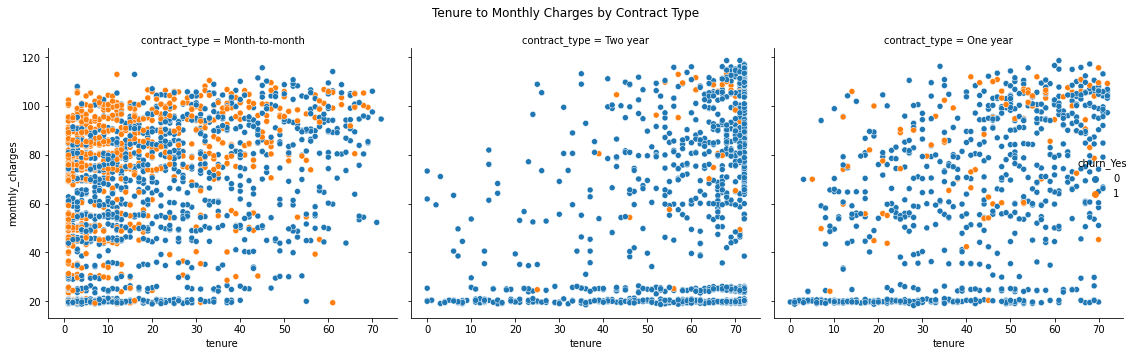

In [112]:
# slight correlation. far less churn and higher tenure in two year contracts.  For what it's worth
rel = sns.relplot(x='tenure', y='monthly_charges', data=telco_X_train, col="contract_type", hue=telco_y_train)
rel.fig.suptitle('Tenure to Monthly Charges by Contract Type') # One way to title a relplot
plt.tight_layout()

### The above charts imply generally more churn for shorter-tenured customers; less clear is the relationship between monthly charges and tenure.  Month-to-month contracts have visibly more churn than other contract durations.

### My hypotheses regarding churn and tenure:

    - 𝐻𝑜 : tenure among churn and non-churn is unrelated
    - 𝐻𝑎 : tenure is related to churn

    - We rejected the null hypothesis

In [22]:
# This cell runs a mann-whitney stats test on tenure vs. churn; the result shows a clear correlation.

mann_whit, p_value = scipy.stats.mannwhitneyu(telco_X_train.tenure, telco_y_train, )


if p_value < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
mann_whit, p_value

We reject the null hypothesis


(188603.0, 0.0)

No handles with labels found to put in legend.


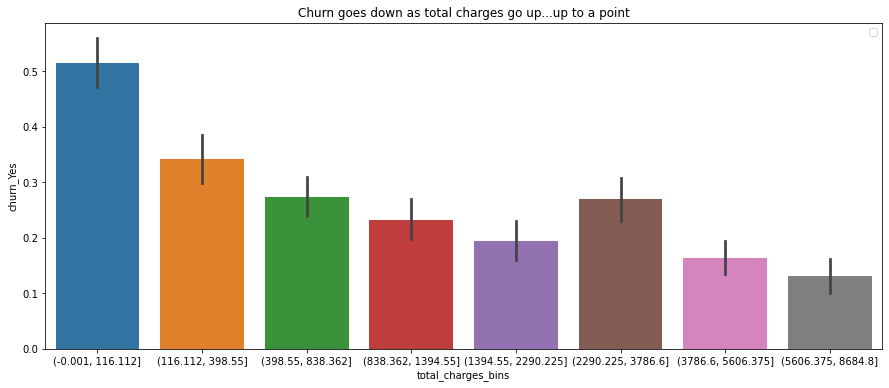

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [23]:
# This cell compares total_charges, which have been separated in 8 bins, to churn
plt.figure(figsize=(15,6))
plt.title("Churn goes down as total charges go up...up to a point")
sns.barplot(y=telco_y_train, x="total_charges_bins", data=telco_X_train)
plt.legend()
plt.show()
plt.tight_layout

### The above chart shows that there is a a point at which, as total charges rise, our customers' churn rate rises before falling again.

### Answer to Research Question 3:

Our mann-whitney test shows that we can proceed with the understanding that tenure is related to churn, obvious as it may seem; customer churn goes down as their lifetime value (measured in total charges) goes up. Interestingly, their is a point at which total charges point to a higher level of churn--perhaps an area for further exploration. 

## Research Question 4

How does the electronic check payment method relates to higher churn?

<AxesSubplot:title={'center':'Way higher churn for electronic check'}, xlabel='payment_type', ylabel='churn_Yes'>

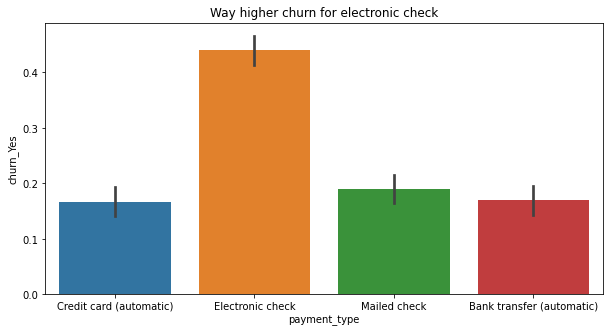

In [31]:
# This simple yet effective chart shows the stark difference in churn for electronic check payments.
plt.figure(figsize=(10,5))
plt.title("Way higher churn for electronic check")
sns.barplot(y=telco_y_train, x= 'payment_type', data=telco_X_train)

In [32]:
# This cell creates a crosstab for use in chi^2 testing.

# Please note that we used the encoded column for electronic check
# This way, we are running the test on echeck only (not on general 'payment method' vs. 'churn')

observed_payment_type_Electronic_check = pd.crosstab(telco_X_train['payment_type_Electronic check'], telco_y_train)

observed_payment_type_Electronic_check

churn_Yes,0,1
payment_type_Electronic check,,
0,2145,456
1,752,590


### My hypotheses vis-a-vis electronic check and churn:

    - 𝐻𝑜 : paying by electronic check is unrelated to churn
    - 𝐻𝑎 : paying by electronic check is related to churn
    
    - We rejected the null hypothesis after testing.

In [33]:
# Creating various variables related to chi^2 testing and printing them below:

chi2, p, degf, expected = stats.chi2_contingency(observed_payment_type_Electronic_check)
print('Observed\n')
print(observed_payment_type_Electronic_check.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed

[[2145  456]
 [ 752  590]]
---
Expected

[[1911  689]
 [ 985  356]]
---

chi^2 = 315.9791
p     = 0.0000
We reject the null hypothesis


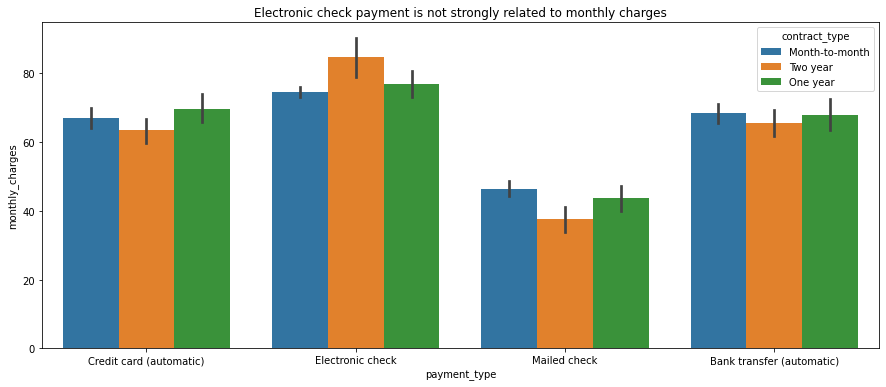

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [34]:
# This cell creates a seaborns barplot to emphasize that in spite of their higher churn,
# customers paying with electronic check don't have considerably higher monthly charges.
plt.figure(figsize=(15,6))
plt.title("Electronic check payment is not strongly related to monthly charges")
sns.barplot(x="payment_type", y='monthly_charges', data=telco_X_train, hue="contract_type")
plt.show()
plt.tight_layout

### Answer to Research Question 4:

The seaborns charts and chi^2 test above demonstrate that paying by electronic check relates to higher churn--in spite of the fact that these customers are not paying very much more per month! One conclusion is that this form of payment relates to a lower commitment to the the company, and therefore higher churn.

## Summary, exploration:

We can proceed with the understanding that customers with dependents churn less; additionally, it is clear from the charts that they are charged less but still provide a higher lifetime value.

We can proceed with the understanding that paperless billing is related to churn; these customers also pay more every month.

We can proceed with the understanding that tenure is related to churn. Interestingly, there is a point at which total charges point to a higher level of churn--perhaps an area for further exploration. 

Paying by electronic check relates to higher churn--in spite of the fact that these customers are not paying very much more per month.


I'd like to proceed with the four features explored here in a future model; currently, my report includes modelling that uses most or all features.

# ON TO MODELLING

### What are we optimizing for?  ACCURACY because we want to pinpoint the best we can the customers who will churn. Not a case of trying to prevent false positives or false negatives, etc; we must specifically identify as exactly as possible those who will churn.

### The top performing models I built were Decision Tree, Random Forest, and KNN model; the best-performing of these, Random Forest, returned just over 74% accuracy.

### What is our baseline? See the following cells:

In [35]:
# Checking which y_tran value is higher to establish baseline. "no churn" wins.
telco_y_train.value_counts()

0    2897
1    1046
Name: churn_Yes, dtype: int64

In [36]:
# Creating a baseline column valued 0 (because no churn, '0', is the baseline)

telco_X_train['baseline'] = 0
telco_X_validate['baseline'] = 0
telco_X_test['baseline']= 0

In [37]:
# Baseline accuracy
baseline_accuracy = (telco_y_train == telco_X_train.baseline).mean()

# print(f'model1 accuracy: {model1_accuracy:.2%}')
# print(f'model2 accuracy: {model2_accuracy:.2%}')
# print(f'model3 accuracy: {model3_accuracy:.2%}')
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.47%


In [38]:
# The decision tree model was throwing errors bc of the string type data in the train set.
# This code uses a function i made to encode and drop columns for the model.  

telco_X_train_encoded = prepare.cols_to_dummy(telco_X_train)

# there were a large number of NaNs in the resulting df, so this code drops them
telco_X_train_encoded = telco_X_train_encoded.dropna()

# Repeat on validate and test sets:
telco_X_validate_encoded = prepare.cols_to_dummy(telco_X_validate)
telco_X_validate_encoded = telco_X_validate_encoded.dropna()

telco_X_test_encoded = prepare.cols_to_dummy(telco_X_test)
telco_X_test_encoded = telco_X_test_encoded.dropna()

# Decision Tree Model

## I'm going to iterate at different max depths in the following cell

In [39]:
# This is Adam's 'for' loop
for i in range(1,21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    # Fit the model (on train and only train)
    tree = tree.fit(telco_X_train_encoded, telco_y_train)
    # Use the model
    y_predictions = tree.predict(telco_X_train_encoded)
    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(telco_y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                     0            1  accuracy    macro avg  weighted avg
precision     0.735466     1.000000  0.735734     0.867733      0.805642
recall        1.000000     0.003824  0.735734     0.501912      0.735734
f1-score      0.847572     0.007619  0.735734     0.427595      0.624749
support    2897.000000  1046.000000  0.735734  3943.000000   3943.000000

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.735466     1.000000  0.735734     0.867733      0.805642
recall        1.000000     0.003824  0.735734     0.501912      0.735734
f1-score      0.847572     0.007619  0.735734     0.427595      0.624749
support    2897.000000  1046.000000  0.735734  3943.000000   3943.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.735466     1.000000  0.735734     0.867733      0.805642
recall        1.000000     0.003824  0.735734  

In [40]:
# Adam's code for a nice, clean view:
metrics = []

for i in range(1, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    # Fit the model (on train and only train)
    tree = tree.fit(telco_X_train_encoded, telco_y_train)
    # Use the model
        # The following line runs the accuracy test on the train data set
    in_sample_accuracy = tree.score(telco_X_train_encoded, telco_y_train)
        # This line runs it on the validate set
    out_of_sample_accuracy = tree.score(telco_X_validate_encoded, telco_y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

# The resulting dataframe returns the accuracy for both datasets and the difference between them
# This will help us decide which max depth provides an adequate accuracy on 'validate,' without overfit

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.735734,0.733885,0.001849
1,2,0.735734,0.733885,0.001849
2,3,0.735734,0.733885,0.001849
3,4,0.737763,0.730337,0.007426
4,5,0.738017,0.726789,0.011228
5,6,0.742582,0.727972,0.014610
6,7,0.748415,0.721467,0.026948
7,8,0.755262,0.715553,0.039710
8,9,0.761349,0.715553,0.045796
9,10,0.771240,0.707274,0.063966


In [41]:
# Commenting out this code, since I didn't ultimately choose the Decision Tree as my best model.

# df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
# plt.ylabel('Accuracy')
# plt.xticks(np.arange(0,21,1))
# plt.grid()

In [42]:
# Here, we're comparing differences between the train and validate data sets
# We throw out any differences above a certain amount (.10) and order by difference as a tie-breaker
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

# The best max_depth, following these criteria, is 1
# Unfortunately, this doesn't beat baseline.

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.735734,0.733885,0.001849
1,2,0.735734,0.733885,0.001849
2,3,0.735734,0.733885,0.001849
3,4,0.737763,0.730337,0.007426
5,6,0.742582,0.727972,0.014610
4,5,0.738017,0.726789,0.011228
6,7,0.748415,0.721467,0.026948
7,8,0.755262,0.715553,0.039710
8,9,0.761349,0.715553,0.045796
9,10,0.771240,0.707274,0.063966


## Given the baseline accuracy, none of the Decision Tree models is very satisfactory

# Random Forest

In [43]:
# Creating lists that i can put into a DF for easy comparison below

# Also, this for loop is creating a list of every possible min_samples_leaf for every max_depth
        # in other words, 20 max_depths * 20 min_leaves


metrics = []

for i in range(20,0, -1):
    for n in range(1, 21):
        # Make the model
        forest = RandomForestClassifier(max_depth=i, min_samples_leaf=n)
        # Fit the model (on train and only train)
        forest.fit(telco_X_train_encoded, telco_y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        in_sample_accuracy = forest.score(telco_X_train_encoded, telco_y_train)
        # And then on validate:
        out_of_sample_accuracy = forest.score(telco_X_validate_encoded, telco_y_validate)

        output = {
            "max_depth": i,
            "min_leaves": n,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy
        }

        metrics.append(output)

df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

# The result, much like with the Decision Tree, is a dataframe that makes comparison of the accuracies easier

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
0,20,1,0.996957,0.729154,0.267802
1,20,2,0.872686,0.729746,0.142940
2,20,3,0.780624,0.735068,0.045556
3,20,4,0.747147,0.733885,0.013262
4,20,5,0.739538,0.734477,0.005062
...,...,...,...,...,...
395,1,16,0.734720,0.734477,0.000243
396,1,17,0.734720,0.734477,0.000243
397,1,18,0.734720,0.734477,0.000243
398,1,19,0.734720,0.734477,0.000243


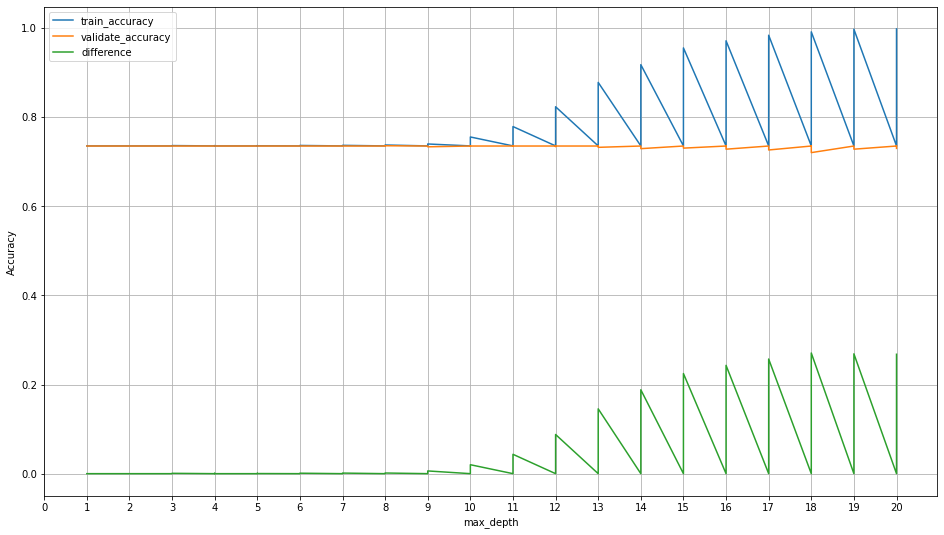

In [44]:
# Graph of the above:

df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [45]:
# Which one did best here? This is sorting the above results by highest 'validate accuracy'

df[df.difference <= 0.05].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
240,8,1,0.736749,0.735068,0.001681
83,16,4,0.744611,0.735068,0.009543
43,18,4,0.746386,0.735068,0.011318
142,13,3,0.747400,0.735068,0.012332
2,20,3,0.780624,0.735068,0.045556
...,...,...,...,...,...
102,15,3,0.763125,0.733294,0.029831
62,17,3,0.770733,0.733294,0.037439
220,9,1,0.739031,0.732703,0.006329
42,18,3,0.778088,0.732111,0.045977


## The top result of the above DF is my chosen model, as it performs better than any other model I ran.  It beats baseline on train and validate (barley). 

    - 8 max depth and 1 min leaves are the parameters, and don't appear to present a problem of overfit (in spite of the seemingly high max depth)

In [47]:
# Creating a RF model to run with the parameters chosen above.

rf = RandomForestClassifier(max_depth = 8, min_samples_leaf=1)
rf = rf.fit(telco_X_train_encoded, telco_y_train)


In [48]:
# the weight assigned to each feature in implementation

print(rf.feature_importances_)

[0.0183879  0.13691385 0.17783046 0.1790975  0.03165301 0.02599091
 0.02374008 0.00549185 0.0050933  0.02112109 0.00159687 0.02016649
 0.00223481 0.01900606 0.00287884 0.02090586 0.00222662 0.01711293
 0.00254479 0.02082124 0.00283757 0.01836565 0.02963629 0.01834292
 0.01492646 0.01081381 0.00229585 0.01885577 0.02272413 0.01786801
 0.01018175 0.01202474 0.01163463 0.00709    0.01079562 0.01207558
 0.01171894 0.00971939 0.01025509 0.00847223 0.00455115 0.        ]


In [49]:
# This would be your csv to include, if the model is ultimately chosen

y_pred = rf.predict(telco_X_train_encoded)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [50]:
# and the probability assigned to each customer

y_pred_proba = rf.predict_proba(telco_X_train_encoded)
y_pred_proba

array([[0.77925441, 0.22074559],
       [0.73506406, 0.26493594],
       [0.78951924, 0.21048076],
       ...,
       [0.59854428, 0.40145572],
       [0.67641834, 0.32358166],
       [0.73606516, 0.26393484]])

In [51]:
# evaluate rf results on train:

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(telco_X_train_encoded, telco_y_train)))

Accuracy of random forest classifier on training set: 0.74


In [52]:
# confusion matrix

labels = sorted(telco_y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(telco_y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,2896,1
1,1042,4


In [53]:
# classification report for the RF model

print(classification_report(telco_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      2897
           1       0.80      0.00      0.01      1046

    accuracy                           0.74      3943
   macro avg       0.77      0.50      0.43      3943
weighted avg       0.75      0.74      0.62      3943



# KNN Model

In [124]:
# Per lecture and exercises, it's important to reduce the number of features when usin KNN bc of problems
# with computation and dimensionality. We will choose the columns to use here.

#(first, I tried with all features for fun)

x_cols = ['tenure', 'monthly_charges', 'total_charges','dependents_Yes',
            'paperless_billing_Yes',
            'payment_type_Electronic check']

# x_cols = ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'partner_Yes','dependents_Yes',
#             'paperless_billing_Yes', 'contract_type_One year', 'contract_type_Two year', 'payment_type_Credit card (automatic)',
#             'payment_type_Electronic check','payment_type_Mailed check']


X_train, y_train = telco_X_train_encoded[x_cols], telco_y_train
X_validate, y_validate = telco_X_validate_encoded[x_cols], telco_y_validate
X_test, y_test = telco_X_test_encoded[x_cols], telco_y_test

### In the following cells, I applied scaling for the KNN model:

In [125]:
# Here, we have applied the standard scaler to the pared-back X_train set from the above cell,
# and calling the variable X_train_scaled (etc):
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

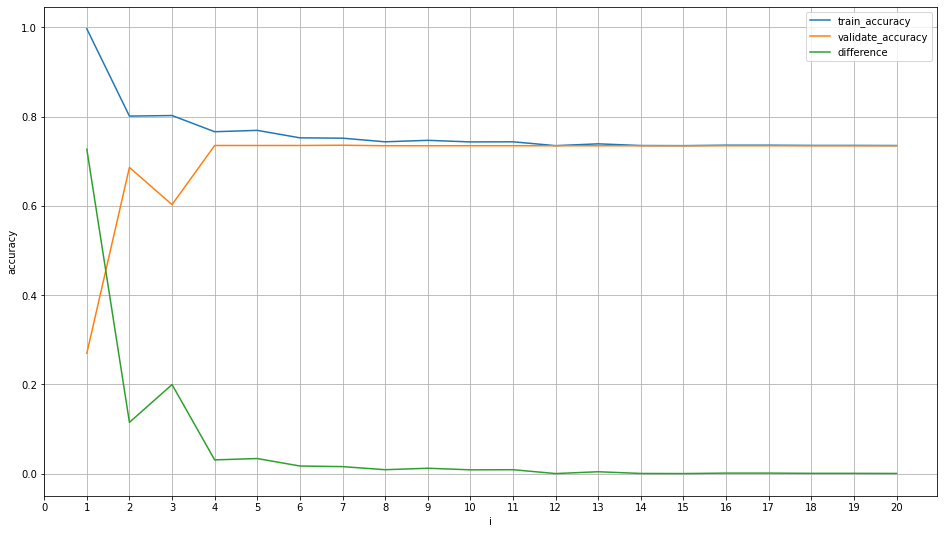

In [126]:
# Was going to comment this cell out, which is code that produces a visualization of my KNN model. 
# I reduced my features again, and still not improving accuracy.
# Ultimately, I'm not using the KNN model as my "best" model.


metrics = []

for i in range(1,21):
    # Make the model
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', algorithm='auto')


    # Fit the model (on train and only train)
    knn.fit(X_train_scaled, telco_y_train)

    # We'll evaluate the model's performance on train and validate
    train_accuracy = knn.score(X_train_scaled, telco_y_train)
    validate_accuracy = knn.score(X_validate, telco_y_validate)

    output = {
        "i": i,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)
    # Produce the classification report on the actual y values and this model's predicted y values
results = pd.DataFrame(metrics)
results["difference"] = results.train_accuracy - results.validate_accuracy
    
# plot it
results.set_index('i').plot(figsize = (16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [127]:
# Commenting out since we are not using the KNN model, and this cell relys on the outputof the above
# Again, ranking the results of the above:

results[results.difference <= 0.1].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,i,train_accuracy,validate_accuracy,difference
6,7,0.751458,0.735659,0.015799
5,6,0.752219,0.735068,0.017151
3,4,0.765914,0.735068,0.030846
4,5,0.768958,0.735068,0.033890
11,12,0.734720,0.734477,0.000243
14,15,0.734720,0.734477,0.000243
13,14,0.734973,0.734477,0.000497
19,20,0.734973,0.734477,0.000497
17,18,0.735227,0.734477,0.000750
18,19,0.735227,0.734477,0.000750


## This model is providing an improved accuracy for the train set, but not an improvement for validate.

# Logistic Regression Model

    - In the end, I am not including a logistic regression model as it failed to outperform any other model

# RUN TOP MODEL ON TEST DATA SET

In [91]:
# Create model for test data:

rf = RandomForestClassifier(max_depth = 16, min_samples_leaf=6)
rf = rf.fit(telco_X_test_encoded, telco_y_test)

# the weight assigned to each feature in implementation

print(rf.feature_importances_)

[0.01655568 0.12865574 0.15734773 0.16802974 0.03469806 0.02844438
 0.02556694 0.00679164 0.00796163 0.02316394 0.00343631 0.01862145
 0.00216897 0.02768988 0.00221524 0.0168754  0.00213232 0.02041243
 0.00402559 0.01826189 0.0030526  0.01685644 0.03469737 0.01733749
 0.01525901 0.01392844 0.00301341 0.01616708 0.02587136 0.01355336
 0.00939381 0.01374851 0.01306559 0.00797718 0.01556122 0.01142116
 0.01025467 0.01126249 0.01161664 0.01564813 0.00725907 0.        ]


In [92]:
# This would be your csv to include, because this is the model you are choosing

y_pred = rf.predict(telco_X_test_encoded)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [93]:
# And the probability assigned to each customer

y_pred_proba = rf.predict_proba(telco_X_test_encoded)
y_pred_proba

array([[0.72196139, 0.27803861],
       [0.89573985, 0.10426015],
       [0.88900908, 0.11099092],
       ...,
       [0.62215236, 0.37784764],
       [0.74251117, 0.25748883],
       [0.69972354, 0.30027646]])

In [94]:
# Evaluate rf results on train:

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(telco_X_test_encoded, telco_y_test)))

Accuracy of random forest classifier on training set: 0.74


In [95]:
# confusion matrix

labels = sorted(telco_y_test.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(telco_y_test, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,0,1
0,1035,0
1,369,5


In [96]:
# classification report for the RF model

print(classification_report(telco_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1035
           1       1.00      0.01      0.03       374

    accuracy                           0.74      1409
   macro avg       0.87      0.51      0.44      1409
weighted avg       0.81      0.74      0.63      1409



In [142]:
# This cell is creating a csv in my current directory, including the prediction and predict_probability

y_pred_df = pd.DataFrame(y_pred)
y_pred_proba_df = pd.DataFrame(y_pred_proba)
churn_pred_df1 = pd.concat([raw_telco_df, y_pred_proba_df])
churn_pred_df2 = pd.concat([churn_pred_df1, y_pred_df])
# Trying to drop columns here.
# cols = ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'partner_Yes','dependents_Yes',
#             'paperless_billing_Yes', 'contract_type_One year', 'contract_type_Two year', 'payment_type_Credit card (automatic)',
#             'payment_type_Electronic check','payment_type_Mailed check']
# churn_pred_df2.drop(columns = 'churn', axis=0)
churn_pred_df2.to_csv('churn_pred.csv')

In [143]:
churn_pred_df2

,0,1,churn,contract_type,contract_type_id,customer_id,dependents,device_protection,gender,internet_service_type,...,partner,payment_type,payment_type_id,phone_service,senior_citizen,streaming_movies,streaming_tv,tech_support,tenure,total_charges
0,NaN,NaN,No,Two year,3.0,0016-QLJIS,Yes,Yes,Female,DSL,...,Yes,Mailed check,2.0,Yes,0.0,Yes,Yes,Yes,65.0,5957.9
1,NaN,NaN,No,Two year,3.0,0017-DINOC,No,No,Male,DSL,...,No,Credit card (automatic),4.0,No,0.0,No,Yes,Yes,54.0,2460.55
2,NaN,NaN,No,Two year,3.0,0019-GFNTW,No,Yes,Female,DSL,...,No,Bank transfer (automatic),3.0,No,0.0,No,No,Yes,56.0,2560.1
3,NaN,NaN,No,Two year,3.0,0056-EPFBG,Yes,Yes,Male,DSL,...,Yes,Credit card (automatic),4.0,No,0.0,No,No,Yes,20.0,825.4
4,NaN,NaN,No,Two year,3.0,0078-XZMHT,No,Yes,Male,DSL,...,Yes,Bank transfer (automatic),3.0,Yes,0.0,Yes,Yes,Yes,72.0,6316.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1405,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1406,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# CONCLUSION: Summary

The modelling that has been done in this report is, unfortunately, somewhat limited in that it has so far been mostly unable to beat our baseline churn prediction by very much.  

Nevertheless, this report has led to a number of interesting conclusions:
    
    - Having dependents relates to lower monthly charges, as well as a higher lifetime value; churn is less prevalent as well.

    - Whatever the benefits of paperless billing, it is also associated with more churn--perhaps because those using it pay more? .

    - The higher the tenure the lower the churn, for obvious reasons. Less obvious is that the higher the lifetime value of a customer, the less the churn. 
        - Significantly, this is only true UP TO A POINT (in the vicinity of 2500 dollars)
    
    - Electronic check payment method relates to higher churn (and barley higher monthly charges). Could this be a segment ripe for loyalty programs?

# CONCLUSION: Recommendations

On a general level, addressing the problem of churn specifically by encouraging GROUP PLANS and AUTOMATIC PAYMENT methods would be of benefit across the board.  These segments of customer have lower churn, and in the case of those with dependents, a higher lifetime value for the company.  To the point, our customers who pay using the electronic payment method churn more (and aren't really paying much more every month); we recommend targeting this segment for loyalty.

Interestingly, we find that churn goes down as lifetime value (total charges) go up--but that at some point, this relationship hits a speed bump where churn takes a step up.  We recommend tracking customers' total charges throughout their time with the company, and offering discounts or other incentives to prevent the "churn bump" that occurs at about $2500 of total charges.

# CONCLUSION: Next Steps

An interesting area for further research will be the relationship of lifetime value and churn, and using this--perhaps using feature engineering--to improve the accuracy of our model.  Likewise, a more detail analysis of segments (the electronic payment customer, for example) that pay the same and churn more could prove to be valuable and perhaps lead to some customer retention insights.  The same goes for other customers that we haven't touched on in this report, such as senior citizens and fiber optics customers, who our analysis did show churn at a higher rate.